## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets based on the different livetimes

### Setup

In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [3]:
%%time
scaled_amplitude = Parameter('amplitude',
                             value = 1e-12)
datasets_input = []
for l in livetimes:
    datasets_i  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_input.append(datasets_i)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-4.641588833612778-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-10.0-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-21.544346900318832-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-46.41588833612777-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
CPU times: user 39.6 s, sys: 1.85 s, total: 41.5 s
Wall time: 41.5 s


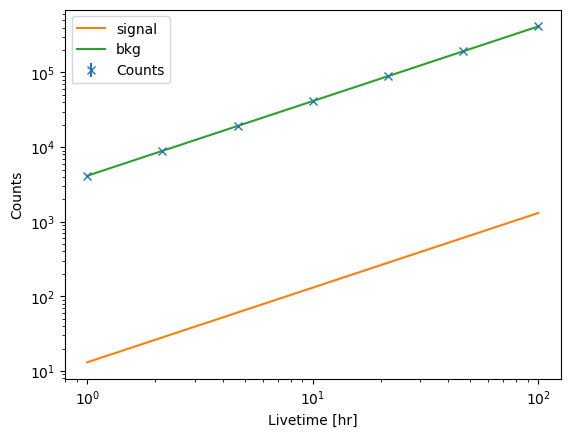

In [4]:
counts, signal, bkg = [] , [], []
for d in datasets_input:
    counts.append(d.counts.data.sum())
    signal.append(d.npred_signal().data.sum())
    bkg.append(d.npred_background().data.sum())
    
    
plt.errorbar(livetimes, counts, yerr = np.sqrt(counts), fmt= 'x', label = "Counts")
plt.plot(livetimes, signal, label = "signal")
plt.plot(livetimes, bkg, label = "bkg")

plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")
plt.legend()

## Asimov Cases

In [5]:
true_energy = datasets_input[0].exposure.geom.axes[0].center.value

In [6]:
datasets = []
for d in datasets_input:
    setup = Setup(dataset_input=d)
    dataset_asimov,_ = setup.run()
    datasets.append(dataset_asimov)


[]

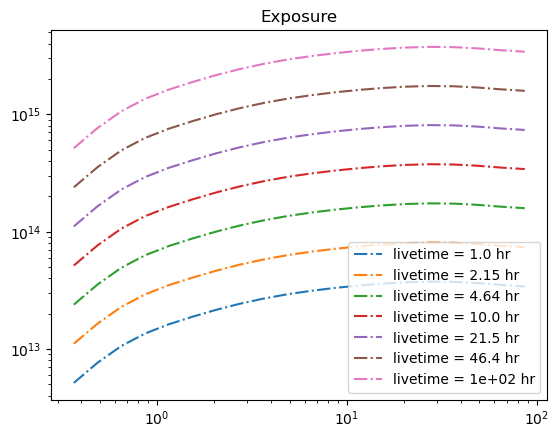

In [7]:
emask = datasets_input[0].mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = datasets_input[0].geoms['geom'].axes[0].center.value[emask]

true_energy = datasets_input[0].exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

[]

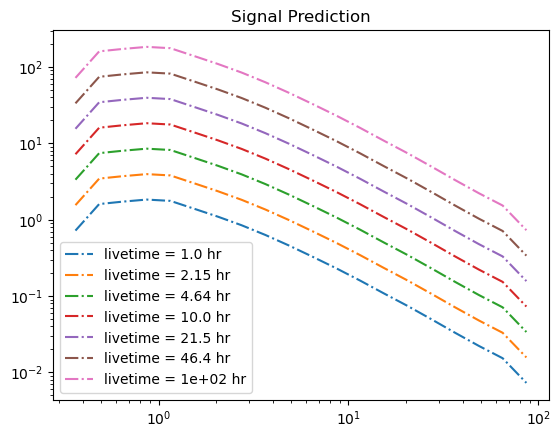

In [8]:

for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

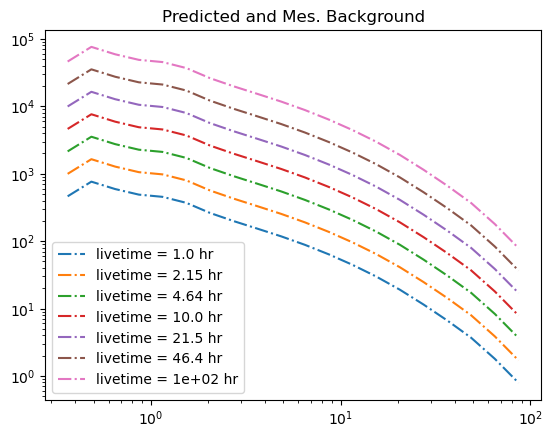

In [9]:
for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.npred_background().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted and Mes. Background")

plt.legend()
plt.loglog()

In [10]:
%%time
fitting = 1

if fitting:
    for i, d in enumerate(datasets):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)

    
    
        print("saving")
        path = f'data/2_model_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets):
        path = f'data/2_model_livetime_{livetimes[i]}.yml'
        datasets[i] = Dataset_load.load_dataset(d, path)        
         
    



0
saving
1
saving
2
saving
3
saving
4
saving
5
saving
6
saving
CPU times: user 55.9 s, sys: 12.7 s, total: 1min 8s
Wall time: 1min 8s


In [11]:
print(datasets[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.46             
    amplitude                     :   1.00e-12   +/- 5.0e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.03 deg         
    lat_0                         :    -30.222   +/-    0.02 deg         

Component 1: FoVBackgroundModel

  Name                      : As09ZHtf-bkg
  Datasets names            : ['As09ZHtf']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.02             
    tilt                          :      0.000   +/-    0.02             
    reference             (frozen):     

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Best Fit Amplitude [1 / (TeV s cm2)]')

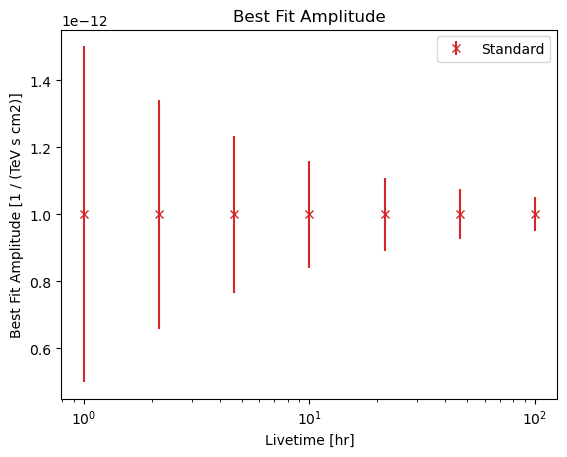

In [12]:
parname = 'amplitude'
for i, d in enumerate(datasets):
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')

plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')

    
plt.title("Best Fit Amplitude")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Amplitude [{par.unit}]")


Text(0, 0.5, 'Best Fit Index')

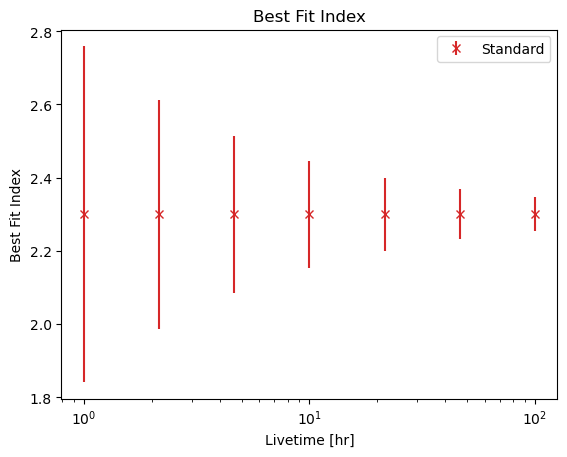

In [13]:
parname = 'index'
for i, d in enumerate(datasets):
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')

plt.title("Best Fit Index")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel("Best Fit Index")


Text(0, 0.5, 'Best Fit BKG Norm')

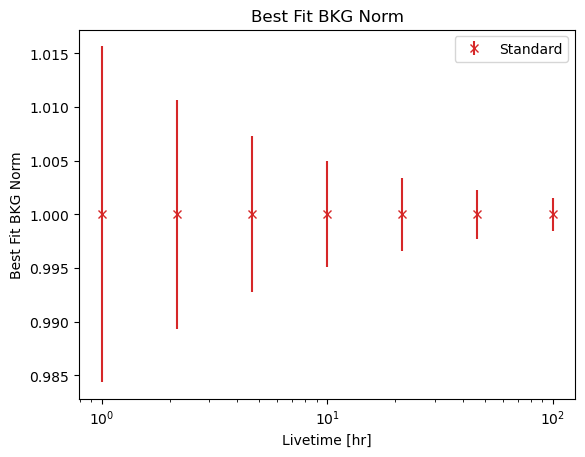

In [14]:
parname = 'norm'
for i, d in enumerate(datasets):
    
    par = d.models.parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')

plt.title("Best Fit BKG Norm")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel("Best Fit BKG Norm")
